Define functions to load in tables of varying depth

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df

def depth1_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = df[df['num_group1'] == 0]
    filfeats = filfeats.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    df = df[df['num_group1'] == 0]
    df = df[df['num_group2'] == 0]
    filterdf = df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    return pd.merge(filterdf, aggfeats, how='left', on='case_id') 

Load in base table

In [2]:
path = '/rds/general/user/ms2524/home/amexproject/parquet_files/train/train_'
base_cba = pd.read_parquet(path + "base.parquet", columns=['case_id','WEEK_NUM','target'])

## Depth = 2

### Credit Bureua A

In [3]:
all_chunks = []
for id in range(11):
    df = filter_df(f'credit_bureau_a_2_{id}')
    processed = depth2_feats(df)
    all_chunks.append(processed)

# Concatenate everything at once
tmp = pd.concat(all_chunks, ignore_index=True)

# Merge with base
data_cba = pd.merge(base_cba, tmp, how="left", on="case_id")


### Previous application

In [4]:
data_appl = pd.merge(
    base_cba,
    depth2_feats(filter_df('applprev_2')),
    how="left",
    on="case_id"
)


## Depth = 1

### Credit Bureua A

In [5]:
data_cba = pd.merge(
    data_cba,
    depth1_feats(pd.concat([filter_df(f'credit_bureau_a_1_{id}') for id in range(4)])),
    how="left",
    on="case_id"
)

### Previous application

In [6]:
data_appl = pd.merge(
    data_appl,
    depth1_feats(pd.concat([filter_df(f'applprev_1_{id}') for id in range(2)])),
    how="left",
    on="case_id"
)


### Train person

In [7]:
data_person_1_train = pd.merge(
    base_cba,
    depth1_feats(filter_df('person_1')),
    how="left",
    on="case_id"
)

## Depth = 0

### Train Static

In [8]:
columns_to_keep = [
    'case_id', 'annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 
    'eir_270L', 'pmtnum_254L', 'lastst_736L', 'totalsettled_863A', 
    'numrejects9m_859L', 'currdebt_22A'
]

data_static_train = pd.merge(
    base_cba,
    pd.concat([
        filter_df(f'static_0_{id}')[columns_to_keep]
        for id in range(2)
    ], ignore_index=True),
    how="left",
    on="case_id"
)

## Feature selection 

In [9]:
for col in data_cba.columns:
    if col.endswith('D'):
        data_cba[col] = pd.to_datetime(data_cba[col], errors='coerce')


for col in data_cba.select_dtypes(include=['object']).columns:
    data_cba[col] = data_cba[col].astype('category')

for col in data_appl.columns:
    if col.endswith('D'):
        data_appl[col] = pd.to_datetime(data_appl[col], errors='coerce')

for col in data_appl.select_dtypes(include=['object']).columns:
    data_appl[col] = data_appl[col].astype('category')

for col in data_static_train.columns:
    if col.endswith('D'):
        data_static_train[col] = pd.to_datetime(data_static_train[col], errors='coerce')

for col in data_static_train.select_dtypes(include=['object']).columns:
    data_static_train[col] = data_static_train[col].astype('category')

for col in data_person_1_train.columns:
    if col.endswith('D'):
        data_person_1_train[col] = pd.to_datetime(data_person_1_train[col], errors='coerce')

for col in data_person_1_train.select_dtypes(include=['object']).columns:
    data_person_1_train[col] = data_person_1_train[col].astype('category')

In [10]:
import numpy as np
cb_features = ['case_id', 'WEEK_NUM','pmts_dpd_1073P', 'pmts_dpd_303P', 'dpdmax_139P', 'numberofoverdueinstlmax_1039L', 'numberofoverdueinstls_725L', 'collaterals_typeofguarante_359M', 'classificationofcontr_400M', 'subjectrole_93M', 'target']
data1_cba=data_cba[cb_features]
data1_cba = data1_cba.copy()
data1_cba.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

applprev_features = ['case_id', 'WEEK_NUM','maxdpdtolerance_577P', 'cacccardblochreas_147M', 'rejectreason_755M','target']
data1_appl=data_appl[applprev_features]
data1_appl = data1_appl.copy()
data1_appl.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

static_features = ['case_id', 'WEEK_NUM','annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 'eir_270L', 'pmtnum_254L', 'lastst_736L']
data_static_train_1 = data_static_train[static_features]
data_static_train_1 = data_static_train_1.copy()
data_static_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

person_features = ['case_id', 'WEEK_NUM','personindex_1023L', 'persontype_1072L', 'persontype_792L', 'empladdr_zipcode_114M', 'incometype_1044T', 'safeguarantyflag_411L', 'type_25L','target']
data_person_1_train_1 = data_person_1_train[person_features]
data_person_1_train_1 = data_person_1_train_1.copy()
data_person_1_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np


# Split by WEEK_NUM into equal segments
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segments[key] = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()

    return segments

def preprocess_split(train_df, test_df):
    exclude_columns = {'case_id', 'WEEK_NUM', 'target'}
    numcols = []
    catcols = []

    # Separate numeric and categorical columns
    for col in train_df.columns:
        if col in exclude_columns:
            continue
        if pd.api.types.is_numeric_dtype(train_df[col]):
            numcols.append(col)
        elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
            catcols.append(col)

    # Impute numeric columns
    for col in numcols:
        if train_df[col].isnull().any():
            strategy = 'median' if abs(train_df[col].skew()) > 0.5 else 'mean'
            imputer = SimpleImputer(strategy=strategy)
            train_df[[col]] = imputer.fit_transform(train_df[[col]])
            test_df[[col]] = imputer.transform(test_df[[col]])

    # Handle categorical columns: fill NA with "Unknown"
    for col in catcols:
        for df in [train_df, test_df]:
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")

        # Fill missing values
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")

    # Ordinal encode
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[catcols] = encoder.fit_transform(train_df[catcols])
    test_df[catcols] = encoder.transform(test_df[catcols])

    return train_df, test_df

def preprocess_all_segments(df, n):
    segments = split_by_week(df, n)
    base_train = segments["split_0"].copy()
    processed_segments = {}

    for key, segment_df in segments.items():
        train_proc, test_proc = preprocess_split(base_train.copy(), segment_df.copy())
        processed_segments[key] = test_proc

    return processed_segments

In [12]:
def merge_all_segments(cba_splits, static_splits, person_splits, appl_splits):
    merged_segments = {}

    drop_cols = ['WEEK_NUM', 'target']

    for split_name in cba_splits:
        cba = cba_splits[split_name]
        static = static_splits[split_name].drop(columns=[col for col in drop_cols if col in static_splits[split_name].columns])
        person = person_splits[split_name].drop(columns=[col for col in drop_cols if col in person_splits[split_name].columns])
        appl = appl_splits[split_name].drop(columns=[col for col in drop_cols if col in appl_splits[split_name].columns])

        merged = cba.merge(static, on="case_id", how="inner") \
                    .merge(person, on="case_id", how="inner") \
                    .merge(appl, on="case_id", how="inner")

        merged_segments[split_name] = merged

    return merged_segments


In [13]:
n_segments = 13

cba_proc = preprocess_all_segments(data1_cba, n=n_segments)
static_proc = preprocess_all_segments(data_static_train_1, n=n_segments)
person_proc = preprocess_all_segments(data_person_1_train_1, n=n_segments)
appl_proc = preprocess_all_segments(data1_appl, n=n_segments)

final_segments = merge_all_segments(cba_proc, static_proc, person_proc, appl_proc)

/rds/general/user/ms2524/ephemeral/ipykernel_3461402/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_3461402/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_3461402/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral

In [14]:
final_segments['split_0'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115189 entries, 0 to 115188
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   case_id                          115189 non-null  int64  
 1   WEEK_NUM                         115189 non-null  int64  
 2   pmts_dpd_1073P                   115189 non-null  float32
 3   pmts_dpd_303P                    115189 non-null  float32
 4   dpdmax_139P                      115189 non-null  float32
 5   numberofoverdueinstlmax_1039L    115189 non-null  float64
 6   numberofoverdueinstls_725L       115189 non-null  float64
 7   collaterals_typeofguarante_359M  115189 non-null  float64
 8   classificationofcontr_400M       115189 non-null  float64
 9   subjectrole_93M                  115189 non-null  float64
 10  target                           115189 non-null  int64  
 11  annuity_780A                     115189 non-null  float32
 12  cr

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize lists to store results
segment_names = []
true_default_rates = []
predicted_default_rates = []
# Set columns to exclude and extract feature names from split_0 (training segment)
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
base_segment = final_segments['split_0']
features = [col for col in base_segment.columns if col not in exclude_cols]

# Prepare training data
X_train = base_segment[features]
y_train = base_segment['target']

# Create and train model
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

# Evaluate on all segments
for key, segment in final_segments.items():
    X_test = segment[features]
    y_test = segment['target']
    y_pred = model.predict_proba(X_test)[:, 1]

    
    segment_names.append(key)
    true_default_rates.append(y_test.mean())
    predicted_default_rates.append(y_pred.mean())
    
    auc = roc_auc_score(y_test, y_pred)
    default_rate = y_test.mean()
    pred_rate = y_pred.mean()
    print(f"{key}: AUC = {auc:.4f}, True Default Rate = {default_rate:.4f}, Predicted Default Rate = {pred_rate:.4f}")

split_0: AUC = 0.6452, True Default Rate = 0.0261, Predicted Default Rate = 0.0261
split_1: AUC = 0.6232, True Default Rate = 0.0271, Predicted Default Rate = 0.0297
split_2: AUC = 0.6357, True Default Rate = 0.0316, Predicted Default Rate = 0.0336
split_3: AUC = 0.6306, True Default Rate = 0.0270, Predicted Default Rate = 0.0245
split_4: AUC = 0.6292, True Default Rate = 0.0269, Predicted Default Rate = 0.0238
split_5: AUC = 0.6187, True Default Rate = 0.0358, Predicted Default Rate = 0.0238
split_6: AUC = 0.6183, True Default Rate = 0.0365, Predicted Default Rate = 0.0238
split_7: AUC = 0.6216, True Default Rate = 0.0364, Predicted Default Rate = 0.0243
split_8: AUC = 0.6202, True Default Rate = 0.0489, Predicted Default Rate = 0.0252
split_9: AUC = 0.6261, True Default Rate = 0.0327, Predicted Default Rate = 0.0229
split_10: AUC = 0.6614, True Default Rate = 0.0233, Predicted Default Rate = 0.0217
split_11: AUC = 0.6498, True Default Rate = 0.0230, Predicted Default Rate = 0.0216
sp

In [25]:
def approval_utility(y_true, y_pred_proba, threshold,
                     reward_approve_good, penalty_approve_bad):
    approve = y_pred_proba < threshold
    approve_good = ((approve == 1) & (y_true == 0)).sum()
    approve_bad = ((approve == 1) & (y_true == 1)).sum()

    return reward_approve_good * approve_good + penalty_approve_bad * approve_bad

def find_best_threshold(y_true, y_pred_proba, utility_func, **kwargs):
    thresholds = np.linspace(0.01, 0.99, 99)  
    best_threshold = 0.5
    best_utility = -np.inf

    for t in thresholds:
        u = utility_func(y_true, y_pred_proba, threshold=t, **kwargs)
        if u > best_utility:
            best_utility = u
            best_threshold = t

    return best_threshold, best_utility



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

results = []

X_train = final_segments['split_0'][features]
y_train = final_segments['split_0']['target']
sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = f"split_{t}"
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train model
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)

    # Predict probabilities of default (class 1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    # Decision threshold
    threshold = 0.5
    accept_mask = y_pred_proba < threshold

    # Compute utility (example: reward good approval +1, penalize bad approval -2)
    utility = approval_utility(y_test, y_pred_proba, threshold,
                            reward_approve_good=1,
                            penalty_approve_bad=-2)

    results.append({
        "segment": split_key,
        "auc": auc,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba.mean(),
        "accept_rate": accept_mask.mean(),
        "utility": utility
    })


    # Update training set with accepted applicants only
    X_train = pd.concat([X_train, X_test[accept_mask]], ignore_index=True)
    y_train = pd.concat([y_train, y_test[accept_mask]], ignore_index=True)

results_df = pd.DataFrame(results)


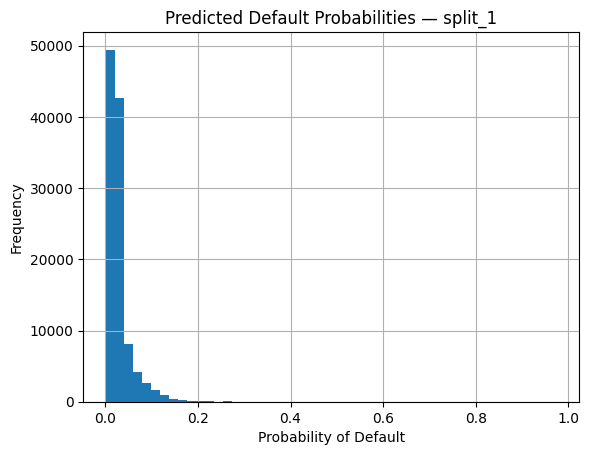

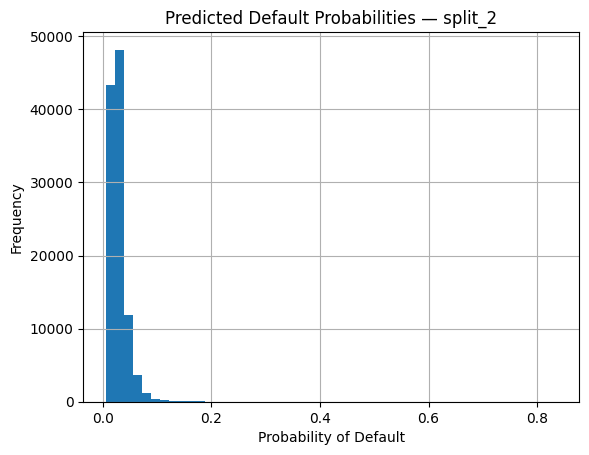

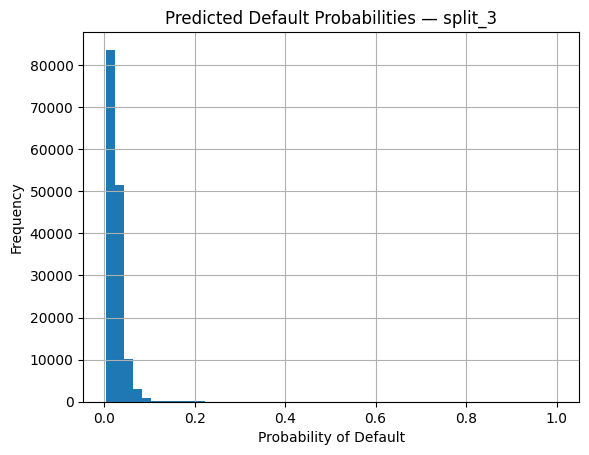

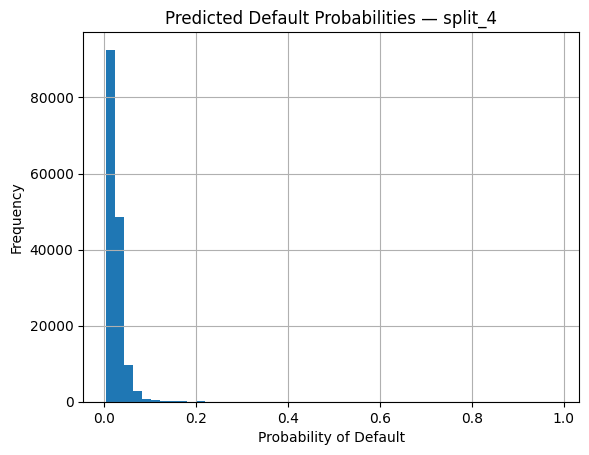

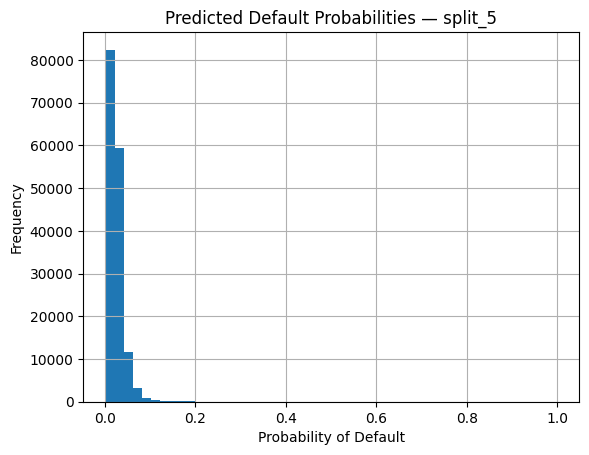

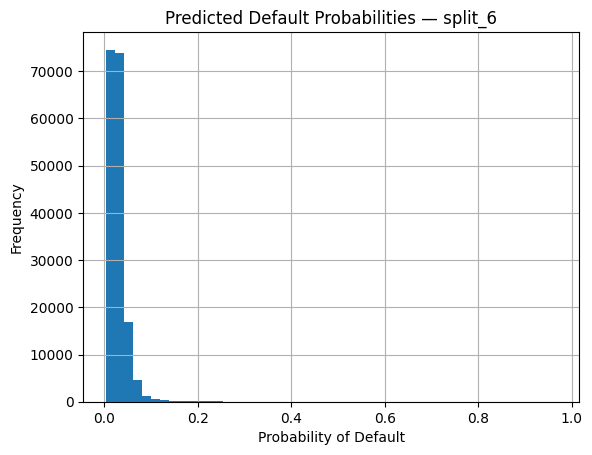

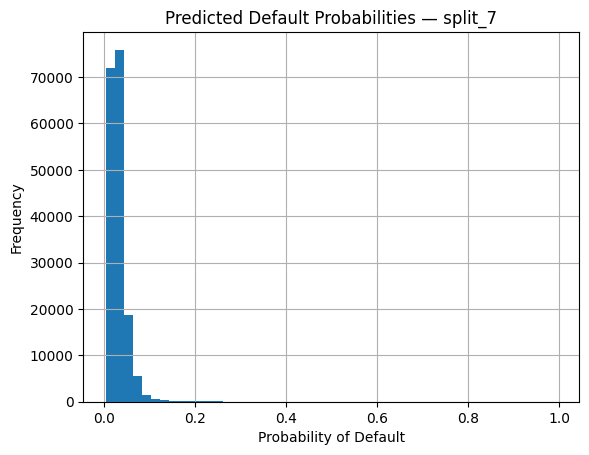

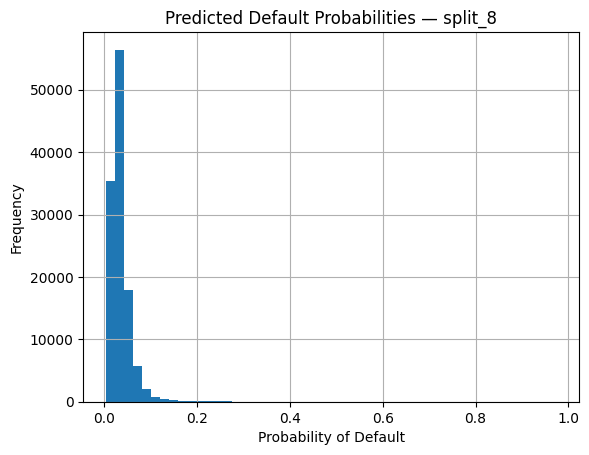

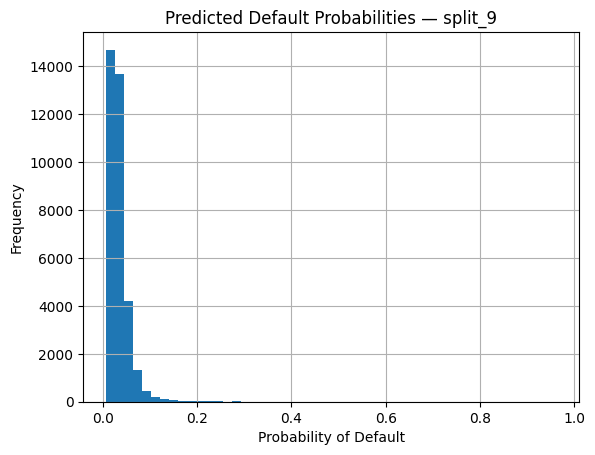

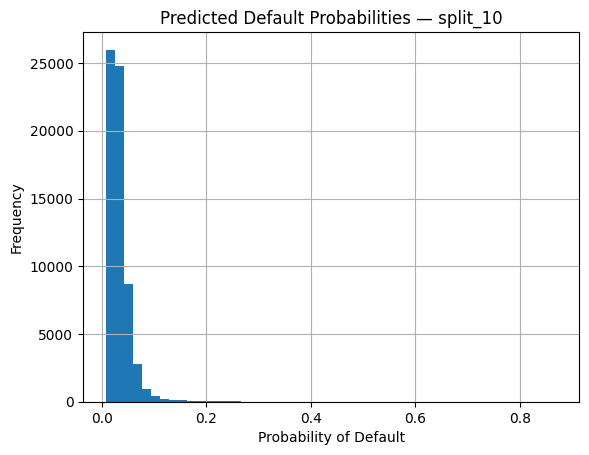

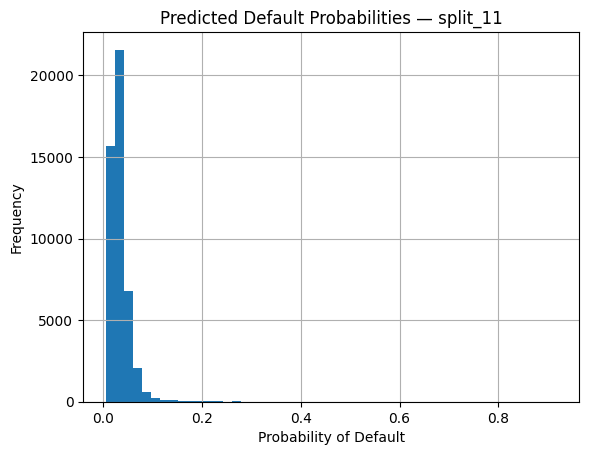

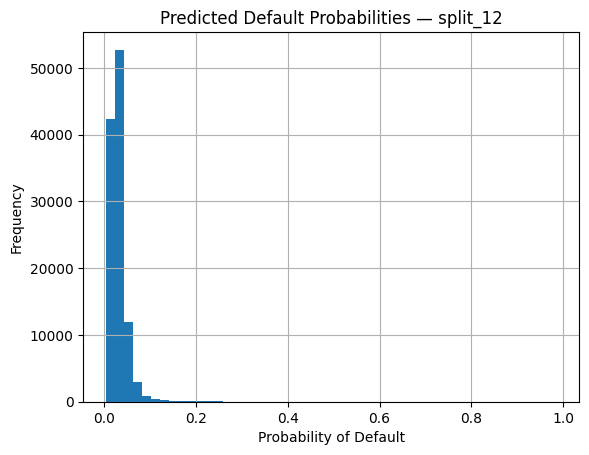

In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# --- Utility Functions ---

def approval_utility(y_true, y_pred_proba, threshold, reward_approve_good=1, penalty_approve_bad=-2):
    approve = y_pred_proba < threshold
    approve_good = ((approve == 1) & (y_true == 0)).sum()
    approve_bad = ((approve == 1) & (y_true == 1)).sum()
    return reward_approve_good * approve_good + penalty_approve_bad * approve_bad

def find_best_threshold(y_true, y_pred_proba, utility_func, **kwargs):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = 0.5
    best_utility = -np.inf
    for t in thresholds:
        u = utility_func(y_true, y_pred_proba, threshold=t, **kwargs)
        if u > best_utility:
            best_utility = u
            best_threshold = t
    return best_threshold, best_utility

# --- Main Evaluation Loop ---

results = []

# Extract feature columns
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[1]))
base_segment = final_segments[sorted_keys[0]]
features = [col for col in base_segment.columns if col not in exclude_cols]

# Initialize training set with split_0
X_train = final_segments['split_0'][features]
y_train = final_segments['split_0']['target']

# Iterate over subsequent splits
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train model
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)

    # Predict probabilities on test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    # Tune threshold using training data
    best_thresh, best_util = find_best_threshold(
        y_train,
        model.predict_proba(X_train)[:, 1],
        approval_utility,
        reward_approve_good=1,
        penalty_approve_bad=-2
    )

    # Make approval decisions
    accept_mask = y_pred_proba < best_thresh

    # Log results
    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "threshold": best_thresh,
        "utility": best_util,
        "auc": auc,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba.mean(),
        "accept_rate": accept_mask.mean()
    })

    # Update training set with only accepted applicants
    X_train = pd.concat([X_train, X_test[accept_mask]], ignore_index=True)
    y_train = pd.concat([y_train, y_test[accept_mask]], ignore_index=True)

# Store results
results_df = pd.DataFrame(results)


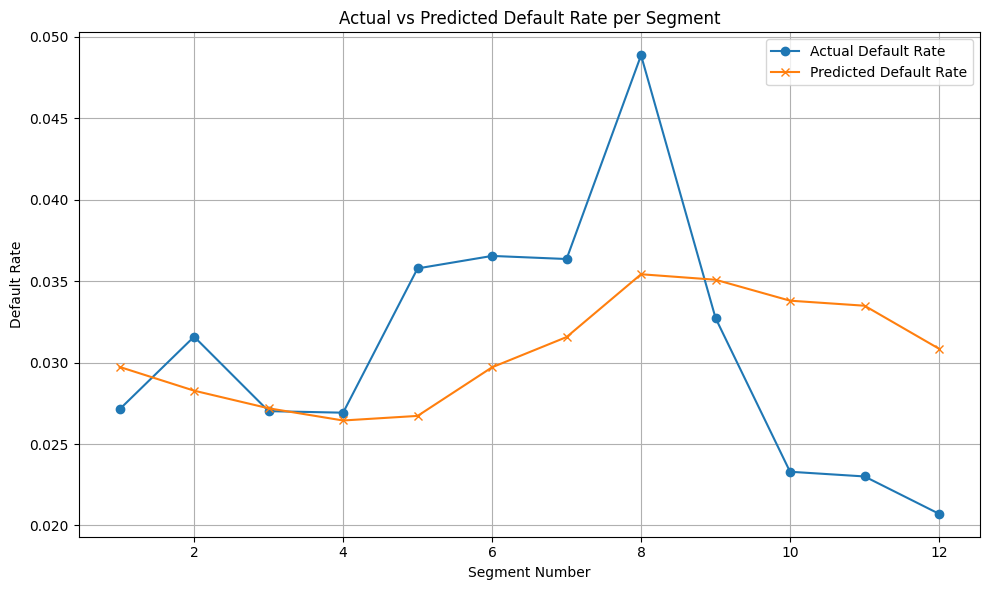

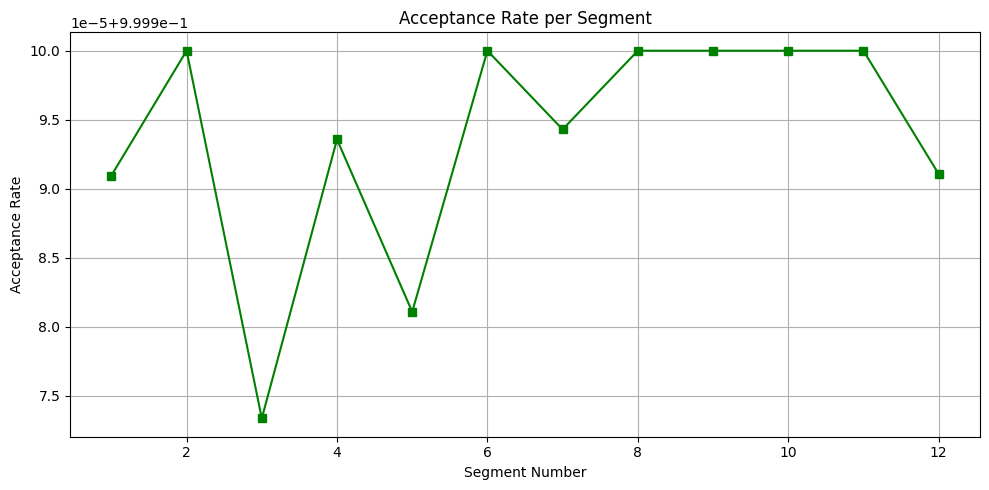

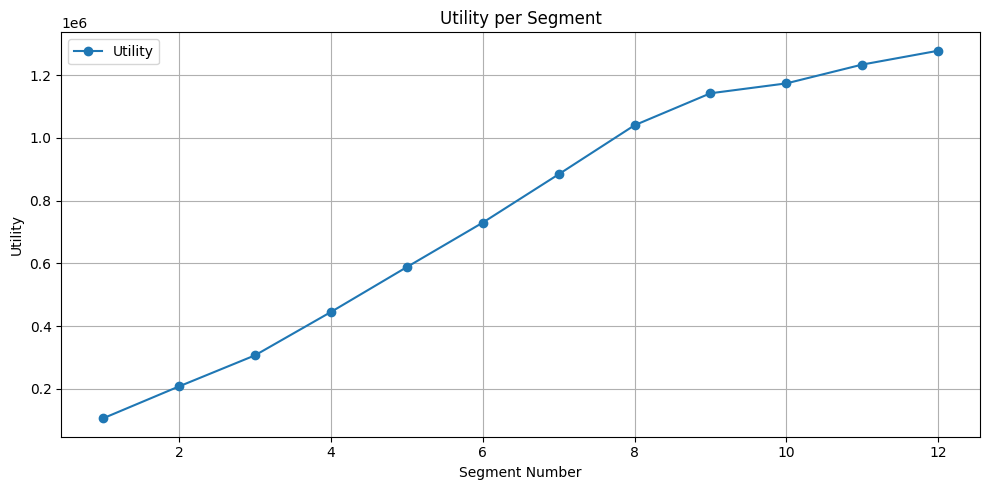

In [27]:
import matplotlib.pyplot as plt

# Convert segment labels like "split_1" to numeric index
results_df["segment_num"] = results_df["segment"].apply(lambda x: int(x.split('_')[1]))

# --- Plot 1: Actual vs Predicted Default Rate ---
plt.figure(figsize=(10, 6))
plt.plot(results_df["segment_num"], results_df["actual_default_rate"], label="Actual Default Rate", marker='o')
plt.plot(results_df["segment_num"], results_df["predicted_default_rate"], label="Predicted Default Rate", marker='x')
plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rate per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Acceptance Rate ---
plt.figure(figsize=(10, 5))
plt.plot(results_df["segment_num"], results_df["accept_rate"], label="Acceptance Rate", marker='s', color='green')
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate per Segment")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results_df["segment_num"], results_df["utility"], marker='o', label="Utility")
plt.xlabel("Segment Number")
plt.ylabel("Utility")
plt.title("Utility per Segment")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
results_df

,segment,segment_num,threshold,utility,auc,actual_default_rate,predicted_default_rate,accept_rate
0,split_1,1,0.96,106153,0.623247,0.027133,0.029731,0.999991
1,split_2,2,0.96,207820,0.643179,0.031589,0.028274,1.000000
2,split_3,3,0.97,306744,0.658798,0.027017,0.027192,0.999973
3,split_4,4,0.97,444835,0.663236,0.026922,0.026443,0.999994
4,split_5,5,0.97,587966,0.653307,0.035778,0.026725,0.999981
5,split_6,6,0.97,729631,0.656405,0.036545,0.029710,1.000000
6,split_7,7,0.98,883656,0.666026,0.036356,0.031564,0.999994
7,split_8,8,0.98,1040004,0.665525,0.048863,0.035420,1.000000
8,split_9,9,0.98,1141933,0.683500,0.032731,0.035083,1.000000
9,split_10,10,0.98,1173480,0.680487,0.023297,0.033798,1.000000


In [33]:
results = []

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # ---- BANDIT MODEL (only approved applicants) ----
    model_bandit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_bandit.fit(X_train_bandit, y_train_bandit)

    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)

    thresh_bandit, util_bandit = find_best_threshold(
        y_train_bandit,
        model_bandit.predict_proba(X_train_bandit)[:, 1],
        approval_utility,
        reward_approve_good=1,
        penalty_approve_bad=-10
    )
    accept_mask_bandit = y_pred_proba_bandit < thresh_bandit

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "threshold": thresh_bandit,
        "utility": util_bandit,
        "auc": auc_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit training data (only approved)
    X_train_bandit = pd.concat([X_train_bandit, X_test[accept_mask_bandit]], ignore_index=True)
    y_train_bandit = pd.concat([y_train_bandit, y_test[accept_mask_bandit]], ignore_index=True)

    # ---- ORACLE MODEL (sees full data) ----
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)

    thresh_oracle, util_oracle = find_best_threshold(
        y_train_oracle,
        model_oracle.predict_proba(X_train_oracle)[:, 1],
        approval_utility,
        reward_approve_good=1,
        penalty_approve_bad=-10
    )
    accept_mask_oracle = y_pred_proba_oracle < thresh_oracle

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "threshold": thresh_oracle,
        "utility": util_oracle,
        "auc": auc_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Oracle adds all test applicants to training
    X_train_oracle = pd.concat([X_train_oracle, X_test], ignore_index=True)
    y_train_oracle = pd.concat([y_train_oracle, y_test], ignore_index=True)

results_df = pd.DataFrame(results)


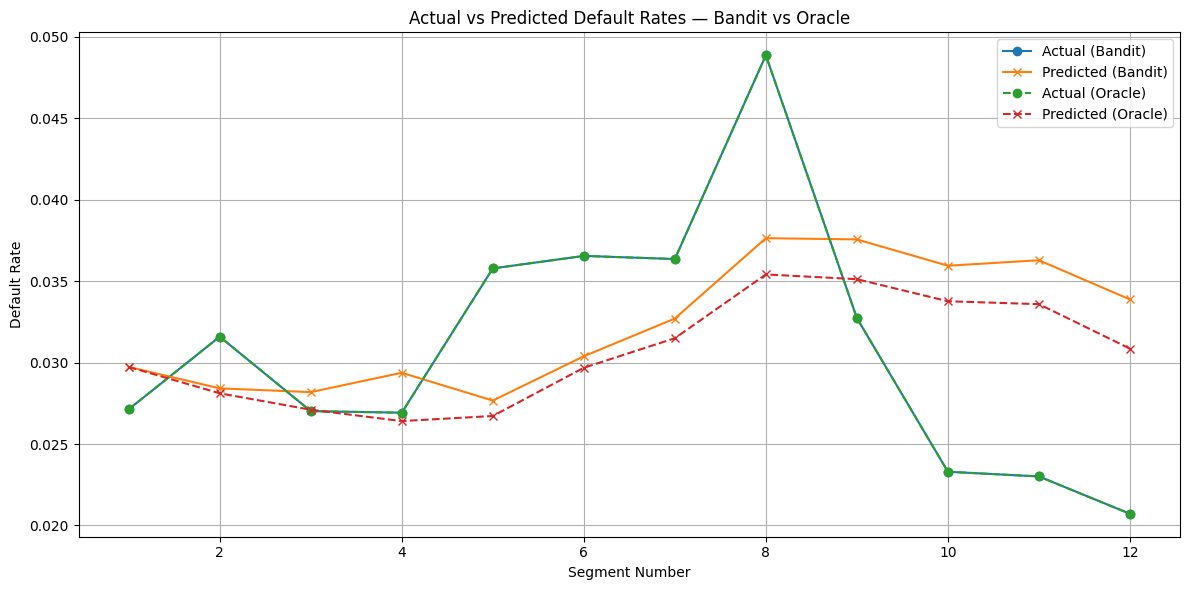

In [34]:
import matplotlib.pyplot as plt

# Split by model type
df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")

# Plot
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual (Bandit)", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["actual_default_rate"], label="Actual (Oracle)", marker='o', linestyle='--')
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
results_df

,segment,segment_num,type,threshold,utility,auc,actual_default_rate,predicted_default_rate,accept_rate
0,split_1,1,bandit,0.12,82183,0.623247,0.027133,0.029731,0.983429
1,split_1,1,oracle,0.12,82183,0.623247,0.027133,0.029731,0.983429
2,split_2,2,bandit,0.09,159700,0.647233,0.031589,0.028416,0.990922
3,split_2,2,oracle,0.09,159925,0.643971,0.031589,0.028112,0.992231
4,split_3,3,bandit,0.08,231551,0.665223,0.027017,0.028185,0.981161
5,split_3,3,oracle,0.09,231630,0.657169,0.027017,0.027103,0.989599
6,split_4,4,bandit,0.86,336747,0.677026,0.026922,0.029373,0.999660
7,split_4,4,oracle,0.10,336931,0.661263,0.026922,0.026407,0.992820
8,split_5,5,bandit,0.67,446324,0.660962,0.035778,0.027665,0.999672
9,split_5,5,oracle,0.11,446289,0.652595,0.035778,0.026720,0.994014
